# GRACE satellite data

Using the GSFC solution

Data from here (using the hdf5 file, but note that there is a PDF with instructions included in the ascii .zip file): https://neptune.gsfc.nasa.gov/gngphys/index.php?section=413 

Visualization tool here : http://ccar.colorado.edu/grace/gsfc.html

In [33]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.interpolate import Rbf, griddata
from scipy.optimize import leastsq, curve_fit
from scipy.stats import chi2
from scipy.ndimage.filters import gaussian_filter
import cartopy.crs as ccrs
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

#%matplotlib notebook
%matplotlib inline

In [3]:
mascons = dict()
with h5py.File('GSFC.glb.200301_201607_v02.4.h5','r') as data:
    mascons['location'] = data.get('/mascon/location').value.squeeze()
    mascons['basin'] = data.get('/mascon/basin').value.squeeze()
    mascons['lon_center'] = data.get('/mascon/lon_center').value.squeeze()
    mascons['lat_center'] = data.get('/mascon/lat_center').value.squeeze()
    mascons['lon_span'] = data.get('/mascon/lon_span').value.squeeze()
    mascons['lat_span'] = data.get('/mascon/lat_span').value.squeeze()
    mascons['yr'] = data.get('/time/yyyy_doy_yrplot_middle').value.squeeze()
    mascons['cmwe'] = data.get('/solution/cmwe').value.squeeze()
    mascons['area_km2'] = data.get('/mascon/area_km2').value.squeeze()
    mascons['leakage_trend'] = data.get('/uncertainty/leakage_trend').value.squeeze()
    mascons['leakage_2sigma'] = data.get('/uncertainty/leakage_2sigma').value.squeeze() 
    mascons['noise_2sigma'] = data.get('/uncertainty/noise_2sigma').value.squeeze()    
    


## Check if I can reproduce the Greenland figure in GSFC_mascons_HDF5_format_v02.4.pdf

(199, 148) (148,) (199,)
0.04057926264387635


Text(0.5,1,'NASA GSFC v02.3c: Greenland Ice Sheet')

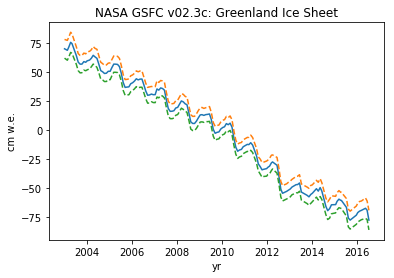

In [4]:
Gndl = np.where(mascons['location'] == 1)[0]
N = float(len(Gndl))
Z = 22 #where does this come from??
t = mascons['yr'][2]
print(mascons['cmwe'][Gndl,:].shape, t.shape, Gndl.shape)
cG = np.array([])
cGe = np.array([])
cmwe2GT = mascons['area_km2'][Gndl]*1e-5
for i in range(len(t)):
    cG = np.append(cG, np.sum(mascons['cmwe'][Gndl,i] * mascons['area_km2'][Gndl]*1e-5))
    leakage_trend = np.abs(np.sum( mascons['leakage_trend'][Gndl,i]*cmwe2GT))
    leakage_2sigma = np.sum(mascons['leakage_2sigma'][Gndl,i]*cmwe2GT)
    noise_2sigma = np.sum(mascons['noise_2sigma'][Gndl,i]*cmwe2GT)
    cGe = np.append(cGe, leakage_trend + (leakage_2sigma + noise_2sigma)/(N/Z)**0.5)
    
GT2cmwe = 1./(np.sum(mascons['area_km2'][Gndl])*1e-5)
print(GT2cmwe)
f,ax = plt.subplots(1,1)
ax.plot(t, cG * GT2cmwe)
ax.plot(t, (cG + cGe) * GT2cmwe, "--")
ax.plot(t, (cG - cGe) * GT2cmwe, "--")
ax.set_xlabel('yr')
ax.set_ylabel('cm w.e.')
ax.set_title('NASA GSFC v02.3c: Greenland Ice Sheet')

100.0


/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


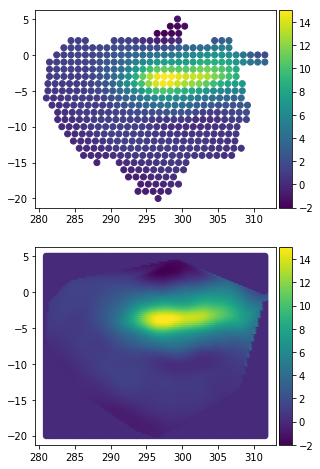

In [5]:
Amz = np.where(np.logical_and(mascons['location'] == 80, mascons['basin'] == 3005))[0]
t = 76
x = np.array([])
y = np.array([])
z = np.array([])
for i in Amz:
    #x = np.append(x, np.array([-1., 1., 1., -1.]) * mascons['lon_span'][i]/2. + mascons['lon_center'][i])
    #y = np.append(y, np.array([-1., -1., 1., 1.]) * mascons['lat_span'][i]/2. + mascons['lat_center'][i])
    x = np.append(x, mascons['lon_center'][i])
    y = np.append(y, mascons['lat_center'][i])
    z = np.append(z, mascons['cmwe'][i,t] * mascons['area_km2'][i]*1e-5)


f,ax = plt.subplots(2,1, figsize=(5, 8))

vmin = min(z)
vmax = max(z)
p0 = ax[0].scatter(x,y, c=z, vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p0, cax = cax)
#f.colorbar(p0, ax = ax[0])

N = 100.
method = "cubic"
print(N)
xgrid = np.linspace(min(x), max(x), N)
ygrid = np.linspace(min(y), max(y), N)

xv, yv = np.meshgrid(xgrid, ygrid)
xvf = xv.flatten()
yvf = yv.flatten()
zgrid = griddata((x,y), z, (xv, yv), method=method, fill_value = 0.)

p1 = ax[1].scatter(xvf ,yvf, c = zgrid.flatten(), vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p1, cax = cax)
#f.colorbar(p1, ax = ax[1])

for a in ax:
    a.set_aspect('equal')


### A full map in Cylindrical Equidistant projection, also known as Equirectangular projection or Plate Carrée

trying to use cartopy http://geologyandpython.com/maps.html


In [6]:
import cartopy.crs as ccrs

#these are defaults that I want to keep for both this t=0 texture and the fit textures
Ngrid = 2.**8.
print(Ngrid)
method = "nearest"
proj = ccrs.PlateCarree(180)


256.0


41168 41168 41168 -11.13989100393677 28.676903189001468 -455.4471740722656 279.88421630859375


/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


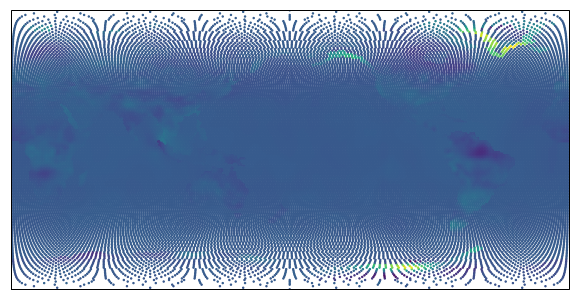

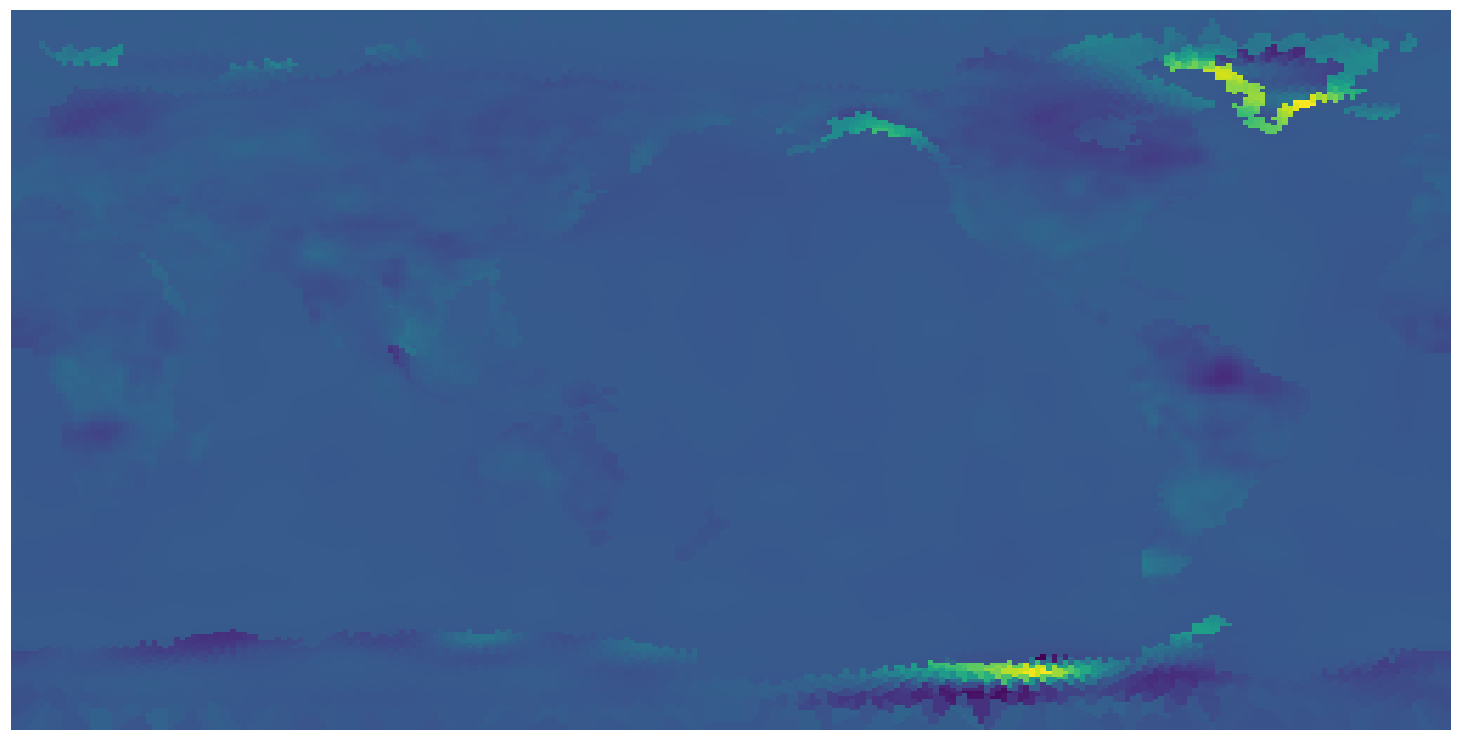

In [7]:

ti = 0 #take the initial time
x =  mascons['lon_center']
y =  mascons['lat_center']
z = mascons['cmwe'][:,ti] * mascons['area_km2']*1e-5
print(x.size, y.size, z.size, min(z), max(z), min(mascons['cmwe'].flatten()), max(mascons['cmwe'].flatten()))

#the degrees in the arg control the central longitude in the scatter plot.  
#I can't do that for the image for some reason.  (can't include ccrs.Geodetic). So this is off by 180 degrees
f,ax = plt.subplots(1,1, figsize=(10, 10), subplot_kw={'projection': proj})

vminc = min(z)
vmaxc = max(z)

ax.projection = proj # Here we change projection for each subplot.
ax.set_global() # Set global extention
p0 = ax.scatter(x,y, c=z, vmin=vminc, vmax=vmaxc, transform=ccrs.Geodetic(), s = 2)
#p0 = ax[0].scatter(xvf,yvf, c=zgrid.flatten(), vmin=vminc, vmax=vmaxc, transform=ccrs.Geodetic(), s = 2)
#f.colorbar(p0, ax = ax[0])
ax.set_aspect('equal')




def makeImage(ti, vmin = None, vmax = None):
    x =  mascons['lon_center']
    y =  mascons['lat_center']
    z = mascons['cmwe'][:,ti] * mascons['area_km2']*1e-5

    xgrid = np.linspace(0, 360, Ngrid)
    ygrid = np.linspace(-90, 90, Ngrid)

    xv, yv = np.meshgrid(xgrid, ygrid)
    xvf = xv.flatten()
    yvf = yv.flatten()
    #This takes WAY too long, but might look better
    #zrbf = Rbf(x, y, z, function='cubic', smooth=0)  
    #zgrid = zrbf(xv, yv)
    zgrid = griddata((x,y), z, (xv, yv), method=method, fill_value = 0.)

    if (vmin == None):
        vmin = np.min(zgrid.flatten())
    if (vmax == None):
        vmax = np.max(zgrid.flatten())
        
    f = plt.figure(figsize=(20,10), frameon=False)
    ax = f.add_axes([0, 0, 1, 1], projection = proj)
    ax.axis('off')
    ax.outline_patch.set_visible(False)
    #ax.imshow(gaussian_filter(zgrid, sigma), extent=[0, 2, 0, 1], aspect='equal', origin="lower", \
    ax.imshow(zgrid, extent=[0, 2, 0, 1], aspect='equal', origin="lower", \
                     vmin=vmin, vmax=vmax, transform=proj)
    #f.savefig('test.png', bbx_inches = 'tight', pad_inches = 0)

    return zgrid

zgrid = makeImage(0, vmin = vminc, vmax = vmaxc)


## image with coastlines

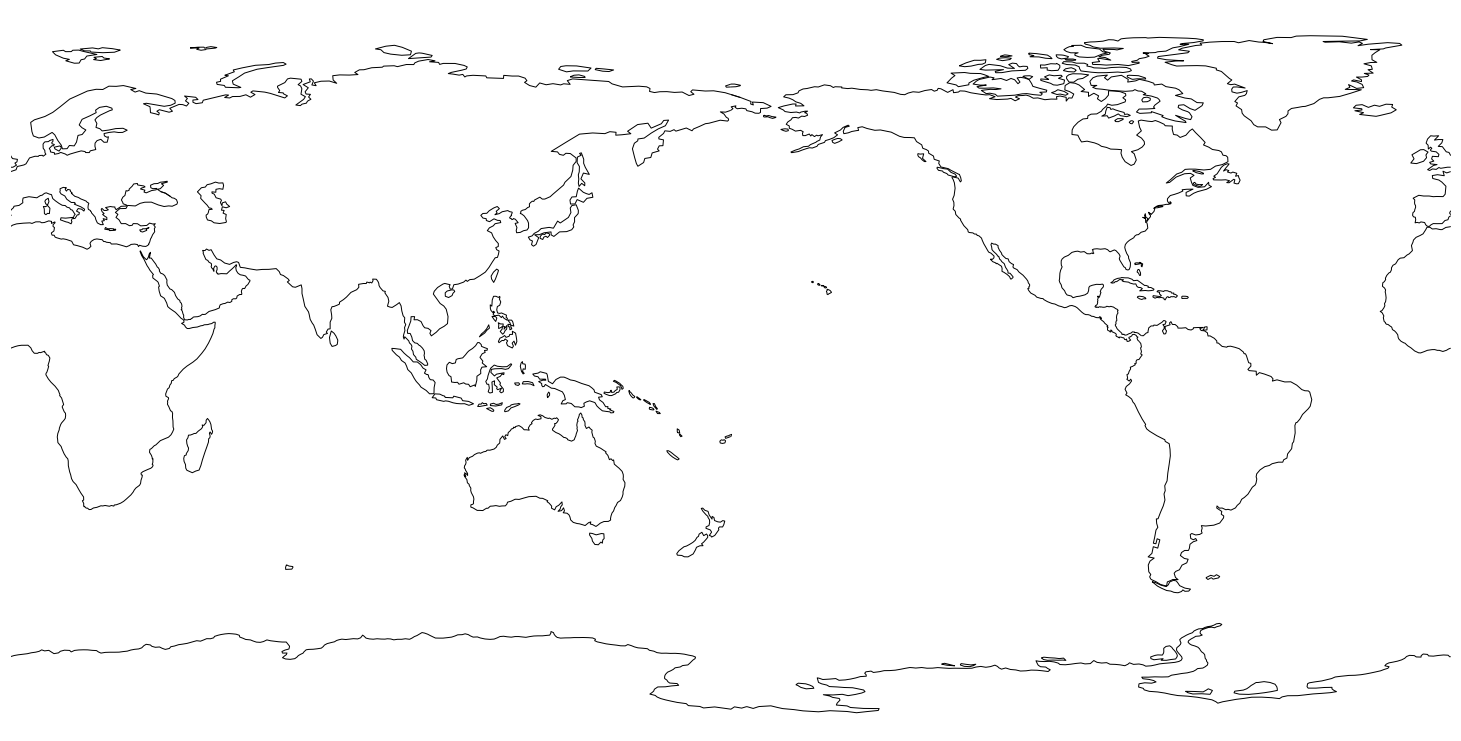

In [22]:
f = plt.figure(figsize=(20,10), frameon=False)
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
ax.coastlines(color='black', linewidth=1)

f.savefig("CoastLines.png", bbx_inches = 'tight', pad_inches = 0,)


### Try to fit a polynomial and sin curve to each pixel in the image as a function of time

In [8]:
def calcChi2(y, ye, m):
    return np.sum((y - m)**2. / ye**2.)

# cmap = plt.get_cmap('viridis') 
# f,ax = plt.subplots(3,1, figsize=(10,5))
# ax[0].set_ylim(-10,10)
# ax[1].set_ylim(-3,3)
# ax[2].set_ylim(-3,3)

t = mascons['yr'][2]
t0 = min(t)
t = t - t0

#for second-order effects, fit sin curve
def cfitFunc(t, fA, fp):
    #require that c is zero and the period is one year
    p = [fA, fp]
    return p[0] * np.sin(2.*np.pi *(t + p[1]))

r = np.array([])
g = np.array([])
b = np.array([])
#a = np.array([])
r2 = np.array([])
g2 = np.array([])
b2 = np.array([])
#a2 = np.array([])
chi2r = np.array([])

#to find how many fits are rejected at 3sigma confidence
bad = 0
dof = len(t) - 6
xx = np.linspace(0,500,1000)
cc = chi2.cdf(xx, dof)
clim = np.interp(0.997,cc,xx)
print("dof : ", dof)
print("chi2_lim : ", clim)
#plt.semilogy(xx,1. - cc)
#plt.plot([clim,clim],[0,1])


for i, m in enumerate(mascons['location']):
    cmwe2GT = mascons['area_km2'][i]*1e-5
    c = mascons['cmwe'][i,:] * cmwe2GT
    leakage_trend = np.abs(mascons['leakage_trend'][i,:]*cmwe2GT)
    leakage_2sigma = mascons['leakage_2sigma'][i,:]*cmwe2GT
    noise_2sigma = mascons['noise_2sigma'][i,:]*cmwe2GT
    cGe = leakage_trend + (leakage_2sigma + noise_2sigma)/(N/Z)**0.5
    
    #normalize by the value at t=0, since that will be in the first texture
    #c0 = c[0]
    #cGe0 = cGe[0]
    #cGe = ( (1./c0)**2.*cGe**2. +  (c/c0**2.)**2.*cGe0**2.)**0.5 #propagation of errors 
    #c = c/c0
    
    #first-order is polynomial
    p = np.polyfit(t, c,  3, w = 1./cGe)

    r = np.append(r,p[0])
    g = np.append(g,p[1])
    b = np.append(b,p[2])

    #b2 = np.append(b2, c0)
    b2 = np.append(b2, p[3])
    
    cf = np.poly1d(p) 

    #2nd order is sin curve
    c2nd = c - cf(t)

    #one sin curve limited such that p = 1 yr and c = 0
    popt, pcov = curve_fit(cfitFunc, t, c2nd, p0 = [np.std(c2nd), 0.], sigma=cGe)#, bounds=[[0, 0], [np.inf, 1.]])#,sigma=cGe)
    fA, fp = popt.ravel()
    fit = cf(t) + fA * np.sin(2.*np.pi*(t + fp))
    r2 = np.append(r2, fA)
    g2 = np.append(g2, fp)
    #print(fA, fp)
    
    #fit = cf(t) + (fA * np.sin(2.*np.pi*t + fp)) * (np.sin(2.*np.pi/fw2*t + fp2))
    c2 = calcChi2(c,cGe, fit)
    chi2r = np.append(chi2r, c2/dof)
    #print(c2/len(t), chi2.cdf(c2, dof))
    if (c2 > clim):
        bad += 1
#     #ax[0].errorbar(t,c ,cGe, color=cmap(bad), alpha = 0.1)
#     ax[0].plot(t,c , color=cmap(bad), alpha = 0.1)
#     ax[0].plot(t,fit, color='k', alpha = 0.1)
#     ax[1].plot(t,c - cf(t), color=cmap(bad), alpha = 0.1)
#     ax[2].plot(t,c - fit, color=cmap(bad), alpha = 0.1)
    
    #plt.subplots_adjust(hspace = 0)
    
    if (i == 0):
        print(p)
        print(np.poly1d(p))
        
#     if (i > 100):
#         break
        
print("N tot = ", len(mascons['location']))
print("N bad = ", bad)
print("frac bad = ",bad / len(mascons['location']) )

dof :  142
chi2_lim :  192.67702200308736
[ 0.01797655 -0.38508793 -0.14502796 12.75461226]
         3          2
0.01798 x - 0.3851 x - 0.145 x + 12.75
N tot =  41168
N bad =  1741
frac bad =  0.0422901282549553


## Check the range of the parameters

-0.02 0.05 -1.12 0.56 -5.05 3.02
-3.98 8.28 -0.33 0.33 -15.82 32.39


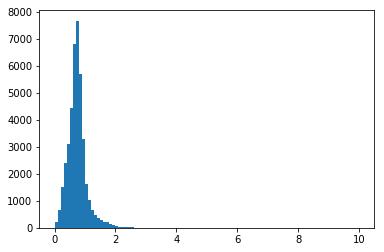

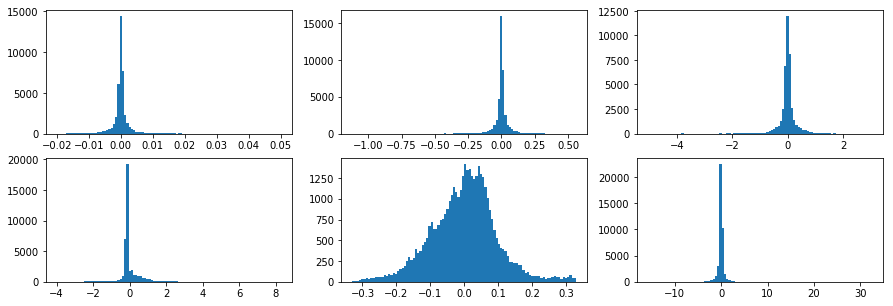

In [9]:
f, ax = plt.subplots(1)
ax.hist(chi2r,bins=100, range=[0, 10])


def myminmax2(x , sfac = 5., decimals = 2):
    m = np.mean(x)
    s = np.std(x)
    return np.around(m - sfac*s, decimals = decimals), np.around(m + sfac*s, decimals = decimals)

def myminmax(x, sfac = 1., decimals = 2):
    return np.around(np.min(x), decimals = decimals), np.around(np.max(x), decimals = decimals)

rmin, rmax = myminmax(r, sfac = 0.5)
gmin, gmax = myminmax(g, sfac = 1.)
bmin, bmax = myminmax(b, sfac = 3.)
print(rmin, rmax, gmin, gmax, bmin, bmax)

r2min, r2max = myminmax(r2, sfac = 0.5)
#r2min = 0.
g2min, g2max = myminmax(g2, sfac = 3.)
#g2min = 0.
#g2max = 1.
b2min, b2max = myminmax(b2, sfac = 2.)
print(r2min, r2max, g2min, g2max, b2min, b2max)

f, ax = plt.subplots(2,3, figsize=(15,5))

h1 = ax[0][0].hist(r, bins=100, range=[rmin,rmax])
h2 = ax[0][1].hist(g, bins=100, range=[gmin,gmax])
h3 = ax[0][2].hist(b, bins=100, range=[bmin,bmax])

h4 = ax[1][0].hist(r2, bins=100, range=[r2min,r2max])
h5 = ax[1][1].hist(g2, bins=100, range=[g2min,g2max])
h6 = ax[1][2].hist(b2, bins=100, range=[b2min,b2max])

## Images for the polynomial fit and sin fit

(normalization is in the 2nd image)

In [19]:
rnorm = np.clip((r - rmin) / (rmax - rmin), 0, 1)
gnorm = np.clip((g - gmin) / (gmax - gmin), 0, 1)
bnorm = np.clip((b - bmin) / (bmax - bmin), 0, 1)

r2norm = np.clip((r2 - r2min) / (r2max - r2min), 0, 1)
g2norm = np.clip((g2 - g2min) / (g2max - g2min), 0, 1)
b2norm = np.clip((b2 - b2min) / (b2max - b2min), 0, 1)

def createFitImage(rn, gn, bn, iname, vmin = 0, vmax = 1, fmethod = "nearest", sigma = [None, None, None]):
#I could use PIL for transparency, but then I don't think I would be able to get the projection I want ?
    x =  mascons['lon_center']
    y =  mascons['lat_center']

    xg = np.linspace(0, 360, Ngrid*2.)
    yg = np.linspace(-90, 90, Ngrid)

    xv, yv = np.meshgrid(xg, yg)
    xvf = xv.flatten()
    yvf = yv.flatten()
    #This takes WAY too long, but might look better
    #zrbf = Rbf(x, y, z, function='cubic', smooth=0)  
    #zgrid = zrbf(xv, yv)
    rg = np.clip(griddata((x,y), rn, (xv, yv), method=fmethod, fill_value = 0.), 0,1)
    gg = np.clip(griddata((x,y), gn, (xv, yv), method=fmethod, fill_value = 0.), 0,1)
    bg = np.clip(griddata((x,y), bn, (xv, yv), method=fmethod, fill_value = 0.), 0,1)
    if (sigma[0] != None):
        rg = gaussian_filter(rg, sigma[0])
    if (sigma[1] != None):
        gg = gaussian_filter(gg, sigma[1])
    if (sigma[2] != None):
        bg = gaussian_filter(bg, sigma[2])
    rgbgrid = np.dstack((rg, gg, bg))
    print(rgbgrid.shape)

#     f = plt.figure(figsize=(20,10), frameon=False)
#     ax = f.add_axes([0, 0, 1, 1], projection = proj)
#     ax.axis('off')
#     ax.outline_patch.set_visible(False)
#     #ax.imshow(gaussian_filter(rgbagrid, sigma), extent=[0, 2, 0, 1], aspect='equal', origin="lower", \
#     #this does not allow alpha values, but I need this to get the projection corrext

#     ax.imshow(rgbgrid, extent=[-180, 180, -90, 90], aspect='equal', origin="lower", \
#                 vmin=vmin, vmax=vmax, transform=proj)
#     ax.coastlines(color='black', linewidth=1)
    
#     f.savefig(iname, bbx_inches = 'tight', pad_inches = 0,)

    im = Image.fromarray((rgbgrid*255.).astype('uint8')).transpose(Image.FLIP_TOP_BOTTOM)
    im.save(iname)
    
    return rg, gg, bg

rgrid, ggrid, bgrid = createFitImage(rnorm, gnorm, bnorm, 'GRACEfit_1.png')
r2grid, g2grid, b2grid = createFitImage(r2norm, g2norm, b2norm, 'GRACEfit_2.png')


    

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


(256, 512, 3)
(256, 512, 3)


## check the fit

256 512
256 512
(256, 512, 3) (256, 512, 3)


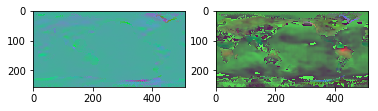

In [20]:
def getImFit(iname):
    pixels = np.asarray(Image.open(iname))
    (ix, iy, foo) = pixels.shape
    print(ix,iy)
    
    Irgrid = np.zeros((ix,iy))
    Iggrid = np.zeros((ix,iy))
    Ibgrid = np.zeros((ix,iy))
    for i in range(ix):
        for j in range(iy):
            Irgrid[i,j] = pixels[i,j,0]/255.
            Iggrid[i,j] = pixels[i,j,1]/255.
            Ibgrid[i,j] = pixels[i,j,2]/255.
        
    return Irgrid, Iggrid, Ibgrid, pixels

Irgrid, Iggrid, Ibgrid, im = getImFit('GRACEfit_1.png')
Ir2grid, Ig2grid, Ib2grid, im2 = getImFit('GRACEfit_2.png')

print(im.shape, im2.shape)
f,ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[1].imshow(im2)

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


(256, 256)


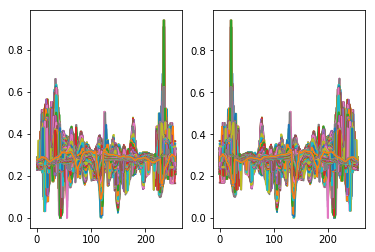

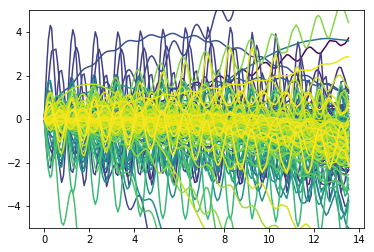

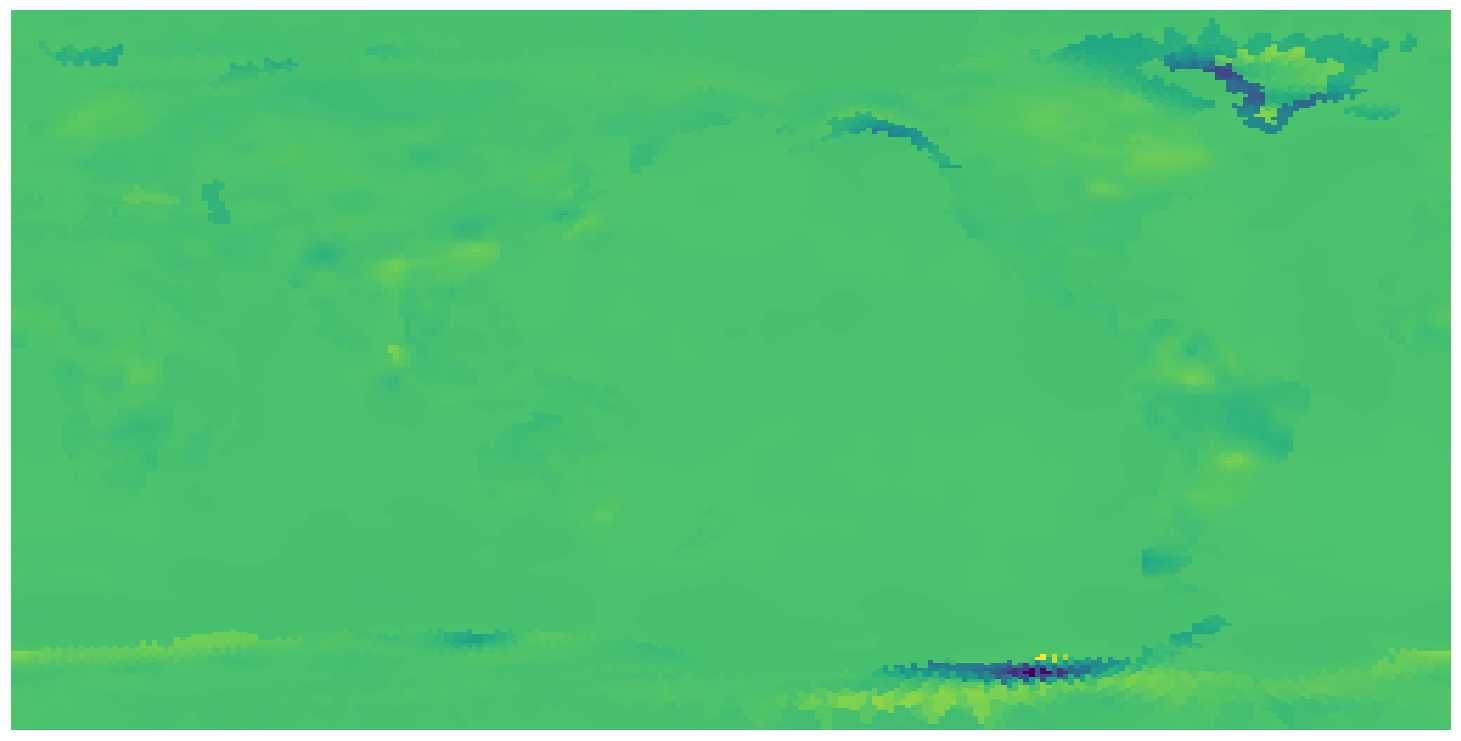

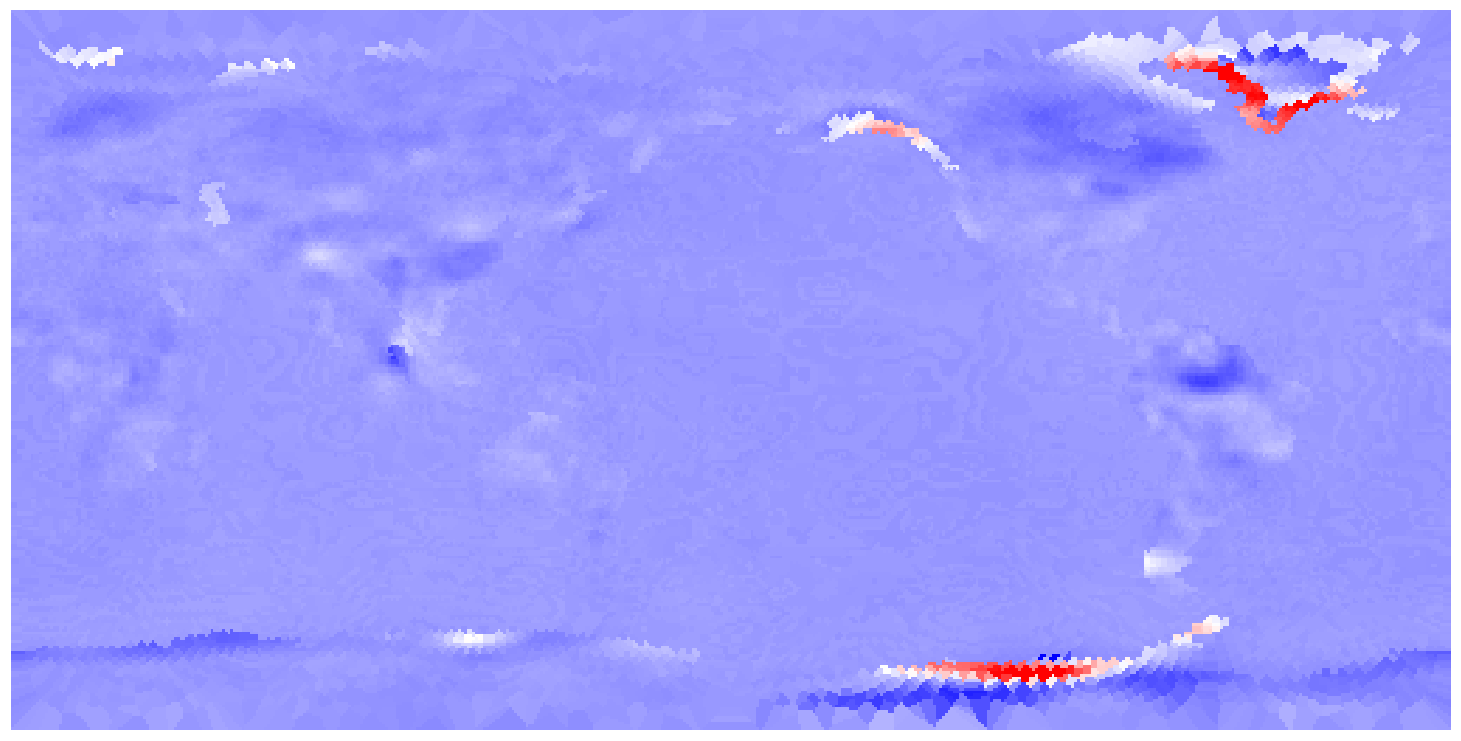

In [23]:
def getCmwe(t, p, p2):
    f1 =  p[0] * t**3. + p[1] * t**2. + p[2] * t + p[3]
    f2 = p2[0] * np.sin(2.*np.pi*(t + p2[1]))
    return (f1 +  f2) 


ti = len(t)-1

rf = Irgrid * (rmax - rmin) + rmin
gf = Iggrid * (gmax - gmin) + gmin
bf = Ibgrid * (bmax - bmin) + bmin

rf2 = Ir2grid * (r2max - r2min) + r2min
gf2 = Ig2grid * (g2max - g2min) + g2min
bf2 = Ib2grid * (b2max - b2min) + b2min

f, ax = plt.subplots(1,2)
ax[0].plot(Irgrid)
ax[1].plot(rgrid)

p = np.array([rf, gf, bf, bf2])
#c0 = bf2

p2 = np.array([rf2, gf2])

t = mascons['yr'][2] - t0

c =  getCmwe(t[ti], p, p2)
ct0 =  getCmwe(t[0], p, p2)

z = mascons['cmwe'][:,ti] * mascons['area_km2']*1e-5

cmap = plt.get_cmap('viridis') 
f = plt.figure()
plt.ylim(-5,5)
p0f = p[0].flatten()
p1f = p[1].flatten()
p2f = p[2].flatten()
p3f = p[3].flatten()
p20f = p2[0].flatten()
p21f = p2[1].flatten()
choose = np.random.randint(low = 0, high = len(p0f)-1, size = 255)
for ic, i in enumerate(choose):
    f1 =  p0f[i] * t**3. + p1f[i] * t**2. + p2f[i] * t + p3f[i]
    f2 = p20f[i] * np.sin(2.*np.pi*(t + p21f[i]))
    cAll = (f1 +  f2) 
    cAll0 = p3f[i] +  p20f[i] * np.sin(2.*np.pi*p21f[i])
    plt.plot(t,cAll - cAll0, c=cmap(ic))

#vmin = min((c-ct0).flatten())
#vmax = max((c-ct0).flatten())
vmin = min(z)
vmax = max(z)

zgrid = makeImage(ti, vmin = vmin, vmax = vmax)
print(zgrid.shape)

cmap = plt.get_cmap('bwr_r') 

f = plt.figure(figsize=(20,10), frameon=False)
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
im = ax.imshow(c - ct0, extent=[0, 2, 0, 1], aspect='equal', origin="upper", \
                 vmin=vmin, vmax=vmax, transform=proj, cmap = cmap)



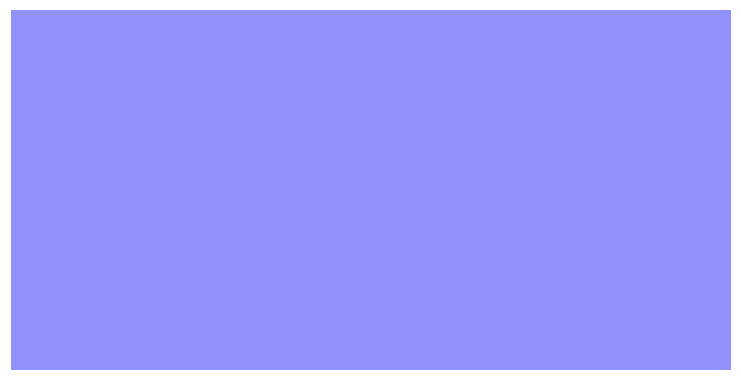

In [41]:
cmap = plt.get_cmap('bwr_r') 

c =  getCmwe(t[0], p, p2)
ct0 =  getCmwe(t[0], p, p2)

f = plt.figure(figsize=(10,5), frameon=False)
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
im = ax.imshow(c - ct0, extent=[0, 2, 0, 1], aspect='equal', origin="upper", \
                 vmin=vmin, vmax=vmax, transform=proj, cmap = cmap)

def init():
    im.set_data(ct0 - ct0)

def animate(i):
    c =  getCmwe(t[i], p, p2)
    im.set_data(c - ct0)
    return im

anim = animation.FuncAnimation(f, animate, init_func=init, frames=len(t), interval=50)

In [42]:
HTML(anim.to_html5_video())

In [ ]:
ti = 76

print("rgb min : ", rmin, gmin, bmin)
print("rgb max : ", rmax, gmax, bmax)
print("rgb2 min : ", r2min, g2min, b2min)
print("rgb2 max : ", r2max, g2max, b2max)
print("t0 : ", t0)
print("tf : ", max(mascons['yr'][2]))
print()

rf = rgrid * (rmax - rmin) + rmin
gf = ggrid * (gmax - gmin) + gmin
bf = bgrid * (bmax - bmin) + bmin

rf2 = r2grid * (r2max - r2min) + r2min
gf2 = g2grid * (g2max - g2min) + g2min
bf2 = b2grid * (b2max - b2min) + b2min

p = np.array([rf, gf, bf, bf2])
#c0 = bf2

p2 = np.array([rf2, gf2])

t = mascons['yr'][2] - t0

f1 =  p[0] * t[ti]**3. + p[1] * t[ti]**2. + p[2] * t[ti] + p[3]
f2 = p2[0] * np.sin(2.*np.pi*(t[ti] + p2[1]))
c = (f1 +  f2) 
ct0 =  p[3] + p2[0] * np.sin(2.*np.pi* p2[1])

print("fit(t[ti]) min, max : ", min(c.flatten()), max(c.flatten()))
print("mean(fit(t=0)) : ", np.mean(ct0))

z = mascons['cmwe'][:,ti] * mascons['area_km2']*1e-5
print("cmwe(t[ti]) min, max : ", min(z),max(z))
#print("cmwe(t=0) min, max from above : ", vminc, vmaxc)
print()

cmap = plt.get_cmap('viridis') 
f = plt.figure()
p0f = p[0].flatten()
p1f = p[1].flatten()
p2f = p[2].flatten()
p3f = p[3].flatten()
p20f = p2[0].flatten()
p21f = p2[1].flatten()
choose = np.random.randint(low = 0, high = len(p0f)-1, size = 255)
for ic, i in enumerate(choose):
    f1 =  p0f[i] * t**3. + p1f[i] * t**2. + p2f[i] * t + p3f[i]
    f2 = p20f[i] * np.sin(2.*np.pi*(t + p21f[i]))
    cAll = (f1 +  f2) 
    plt.plot(t,cAll, c=cmap(ic))

    
cG = mascons['cmwe'].copy()
for i in range(len(cG[0,:])):
    cG[:,i] *= mascons['area_km2']*1e-5

cmin = 0.
cmax = 0.
cmin0 = 0.
cmax0 = 0.

for i,tt in enumerate(t):
    f1 =  p[0] * tt**2. + p[1] * tt + p[2]
    f2 = p2[0] * np.sin(2.*np.pi*tt + p2[1])
    cAll = (f1 +  f2)
    cmin = np.min([np.min(cAll), cmin])
    cmax = np.max([np.max(cAll), cmax])
    cAll = (f1 +  f2) - ct0
    cmin0 = np.min([np.min(cAll), cmin0])
    cmax0 = np.max([np.max(cAll), cmax0])    
print("fit(all t) - ct0 min, max :", cmin0, cmax0)
print("fit(all t) min, max :", cmin, cmax)
print("cmwe(all t) min, max :", min(cG.flatten()), max(cG.flatten()))
print()

#vmin = min(c.flatten())
#vmax = max(c.flatten())

#vmin = min(z)
#vmax = max(z)

vmin = cmin
vmax = cmax

zgrid = makeImage(ti, vmin = vmin, vmax = vmax)
print(zgrid.shape)

f = plt.figure(figsize=(20,10), frameon=False)
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
ax.imshow(c, extent=[0, 2, 0, 1], aspect='equal', origin="lower", \
                 vmin=vmin, vmax=vmax, transform=proj)

diff = zgrid - c
f = plt.figure(figsize=(20,10), frameon=False)
ax = f.add_axes([0, 0, 1, 1], projection = proj)
ax.axis('off')
ax.outline_patch.set_visible(False)
ax.imshow(diff, extent=[0, 2, 0, 1], aspect='equal', origin="lower", \
                 vmin=-1, vmax=1, transform=proj)

rng = [np.min(diff.flatten()), np.max(diff.flatten())]
print("range, mean, stdev of data - model : ", rng, np.mean(diff.flatten()), np.std(diff.flatten()))
f = plt.figure(figsize=(10,5))
x = plt.hist(diff.flatten(), bins=100, range=rng)